<a href="https://colab.research.google.com/github/iambaangkok/261459-Deep-Learning/blob/master/Identification_of_Surface_Cracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from kaggle

In [1]:
! pip install -q kaggle

In [2]:
%reset -f

from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iambaangkok","key":"4dc0b759a44f63015879dfef976d16d1"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# ! kaggle datasets list

In [8]:
! kaggle datasets download -d arunrk7/surface-crack-detection

 89% 207M/233M [00:01<00:00, 172MB/s]
100% 233M/233M [00:01<00:00, 165MB/s]


In [10]:
! mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [9]:
! unzip surface-crack-detection.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Positive/15001_1.jpg  
  inflating: dataset/Positive/15002_1.jpg  
  inflating: dataset/Positive/15003_1.jpg  
  inflating: dataset/Positive/15004_1.jpg  
  inflating: dataset/Positive/15005_1.jpg  
  inflating: dataset/Positive/15006_1.jpg  
  inflating: dataset/Positive/15007_1.jpg  
  inflating: dataset/Positive/15008_1.jpg  
  inflating: dataset/Positive/15009_1.jpg  
  inflating: dataset/Positive/15010_1.jpg  
  inflating: dataset/Positive/15011_1.jpg  
  inflating: dataset/Positive/15012_1.jpg  
  inflating: dataset/Positive/15013_1.jpg  
  inflating: dataset/Positive/15014_1.jpg  
  inflating: dataset/Positive/15015_1.jpg  
  inflating: dataset/Positive/15016_1.jpg  
  inflating: dataset/Positive/15017_1.jpg  
  inflating: dataset/Positive/15018_1.jpg  
  inflating: dataset/Positive/15019_1.jpg  
  inflating: dataset/Positive/15020_1.jpg  
  inflating: dataset/Positive/15021_1.jpg  
  inflating: dataset/Posi

# Split data into train - test

In [11]:
import os
import numpy as np
import shutil

In [12]:
# # Creating Train / Val / Test folders (One time use)
root_dir = 'dataset'
posCls = '/Positive'
negCls = '/Negative'

os.makedirs(root_dir +'/train' + posCls)
os.makedirs(root_dir +'/train' + negCls)
os.makedirs(root_dir +'/val' + posCls)
os.makedirs(root_dir +'/val' + negCls)
os.makedirs(root_dir +'/test' + posCls)
os.makedirs(root_dir +'/test' + negCls)

In [13]:
# Creating partitions of the data after shuffeling
def loadDataset(currentCls):
  src = "dataset"+currentCls # Folder to copy images from

  train_ratio = 0.7
  val_ratio = 0.15
  test_ratio = 0.15

  allFileNames = os.listdir(src)
  np.random.shuffle(allFileNames)
  train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                            [int(len(allFileNames)*(1 - (val_ratio + test_ratio))), 
                                                            int(len(allFileNames)*(1 - val_ratio))])


  train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
  test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

  print('Total images: ', len(allFileNames))
  print('Training: ', len(train_FileNames))
  print('Validation: ', len(val_FileNames))
  print('Testing: ', len(test_FileNames))

  # Copy-pasting images
  for name in train_FileNames:
      shutil.copy(name, "dataset/train"+currentCls)

  for name in val_FileNames:
      shutil.copy(name, "dataset/val"+currentCls)

  for name in test_FileNames:
      shutil.copy(name, "dataset/test"+currentCls)

In [14]:
loadDataset(posCls)

Total images:  20000
Training:  14000
Validation:  3000
Testing:  3000


In [15]:
loadDataset(negCls)

Total images:  20000
Training:  14000
Validation:  3000
Testing:  3000


# Load data into DataLoader

In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torchvision

from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

In [18]:
batch_size = 256

transform = torchvision.transforms.Compose([ 
                  torchvision.transforms.ToTensor(),
                  #torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

ds_train = "dataset/train"
ds_val = "dataset/val"
ds_test  = "dataset/test"

ds_train = ImageFolder(root=ds_train, transform=transform)
ds_val = ImageFolder(root=ds_val, transform=transform)
ds_test = ImageFolder(root=ds_test, transform=transform)
                                    
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val   = DataLoader(ds_val, batch_size=batch_size)
dl_test  = DataLoader(ds_test, batch_size=batch_size)

## Sample images

In [19]:
labels_map = {
    0: "Negative",
    1: "Positive",
}

rgb_map = {
    0: "R",
    1: "G",
    2: "B",
}

Define sampleImage()

In [20]:
def sampleImage(imgCount = 1, splitChannel = False, width = 15, height = 15):
  if splitChannel:
    fig, ax = plt.subplots(imgCount,3,figsize=(height,width))
    for j in range(0,imgCount):
      sample_idx = torch.randint(len(ds_train), size=(1,)).item()
      img, label = ds_train[sample_idx]
      imgs = []
      for i in range(0,3):
        imgs.append(img.permute([1,2,0])[:,:,i])
        if imgCount == 1:
          ax[i].imshow(imgs[i], cmap='viridis'), ax[i].set_title(f"{sample_idx} {labels_map[label]} {rgb_map[i%3]} \nmax= {str(imgs[0].max().item())} \nmin= + {str(imgs[0].min().item())}", fontsize=16)
        else:
          ax[j][i].imshow(imgs[i], cmap='viridis'), ax[j][i].set_title(f"{sample_idx} {labels_map[label]} {rgb_map[i%3]} \nmax= {str(imgs[0].max().item())} \nmin= + {str(imgs[0].min().item())}", fontsize=16)
  else:
    nRows = int((imgCount-1)/3+1)
    fig, ax = plt.subplots(nRows,3,figsize=(height,width))
    for i in range(0,nRows*3):
        sample_idx = torch.randint(len(ds_train), size=(1,)).item()
        img, label = ds_train[sample_idx]
        img = img.permute([1,2,0])
        if imgCount <= 3:
          if i >= imgCount:
            ax[i].axis("off")
          else:
            ax[i].imshow(img, cmap='viridis'), ax[i].set_title(f"{sample_idx} {labels_map[label]} RGB \nmax= {str(img.max().item())} \nmin= + {str(img.min().item())}", fontsize=16)
        else:
          if i >= imgCount:
            ax[int(i/3)][i%3].axis("off")
          else:
            ax[int(i/3)][i%3].imshow(img, cmap='viridis'), ax[int(i/3)][i%3].set_title(f"{sample_idx} {labels_map[label]} RGB \nmax= {str(img.max().item())} \nmin= + {str(img.min().item())}", fontsize=16)
          

    # fig, ax = plt.subplots(1,1,figsize=(height,width))
    # ax.imshow(img.permute([1,2,0]))
    # ax.set_title(f"{sample_idx} {labels_map[label]} RGB \nmax= {str(img.max().item())} \nmin= + {str(img.min().item())}", fontsize=16)

Sample images: RGB

> result is best when imgCount is divisible by 3

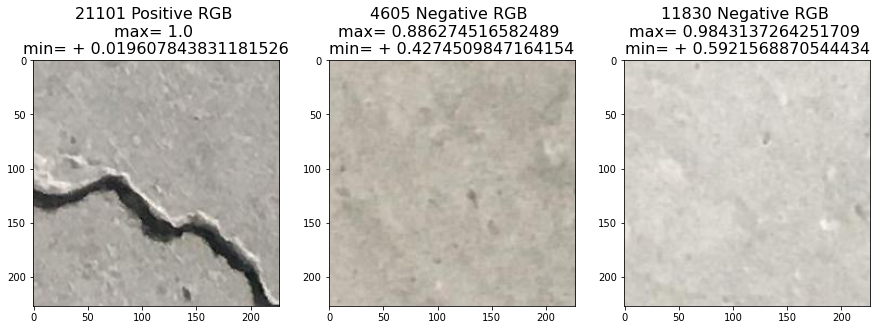

In [21]:
sampleImage(3)

Sample images: split channel

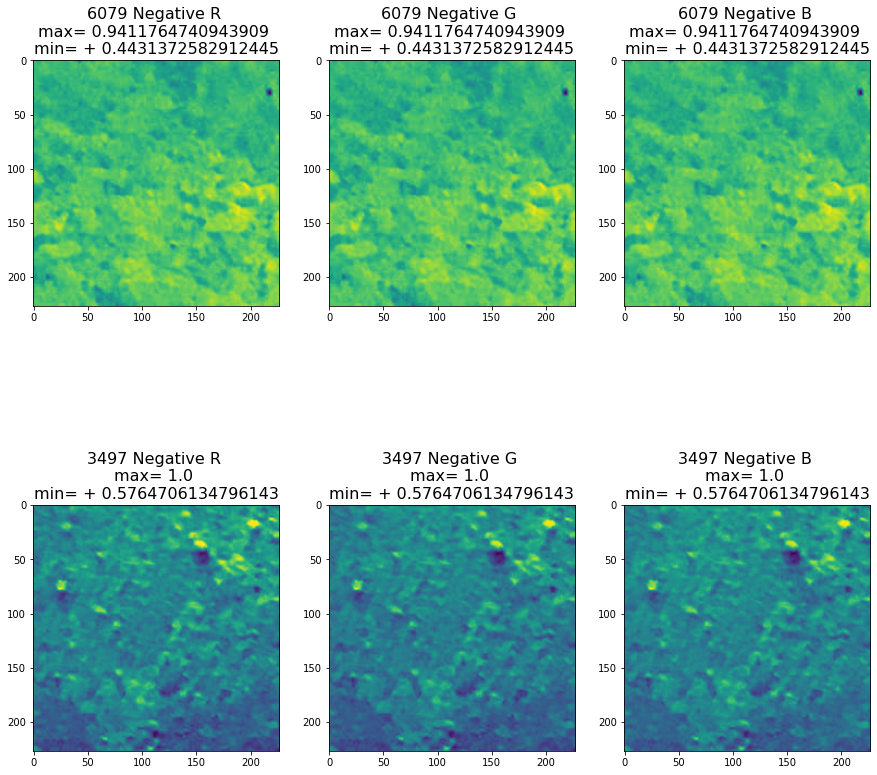

In [22]:
sampleImage(2, splitChannel=True)

# Create model

> parameters are automatically randomized everytime a model is created

Pretrained models

In [20]:
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model(torch.zeros(1024,3,227,227)).size()

torch.Size([128, 1000])

Custom models

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

model = nn.Sequential(
    
    nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=2),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),

    nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),

    nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),

    nn.Conv2d(128, 64, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),

    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(64, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 2),

    nn.Softmax(1)
)

model(torch.zeros(256,3,227,227)).size()

torch.Size([128, 2])

In [22]:
params = list(model.named_parameters())
name, param = params[0]
# if param.requires_grad: 
  # print(name, param.data)

In [23]:
# nn.CrossEntropyLoss = nn.LogSoftmax + `nn.NLLLoss
loss_fn = nn.CrossEntropyLoss()  # 
optimizer = optim.Adam( model.parameters(), lr=0.005 )

In [ ]:
num_epoch = 10
# model = model.to('cuda:0')

for epoch in range(num_epoch):
    trn_loss, val_loss = 0.0, 0.0    
    correct, val_correct = 0, 0

    model.train()    
    for i,(x, y) in enumerate(dl_train):
        # x, y = x.to('cuda:0'), y.to('cuda:0')
        #y_onehot = nn.functional.one_hot(y, num_classes=10).float()   

        # nn.CrossEntropyLoss()( y_pred, y )
        # Note that: y can be either one-hot or class index
        
        optimizer.zero_grad()
        y_predict = model(x)        
        loss = loss_fn(y_predict, y)  # nn.CrossEntropyLoss      
        loss.backward()
        optimizer.step()
        
        trn_loss += loss.item()

        pred = y_predict.argmax(dim=1, keepdim=True)          
        correct += pred.eq(y.view_as(pred)).sum().item()
        if(i%10 == 0):
          print(f'Epoch {epoch} Batch {i}: loss: {loss}')            
        
    print(f'Epoch {epoch}: Train loss: {trn_loss/len(dl_train):8.5f}, Train acc: {100*correct/len(dl_train.dataset):6.2f}%')            

    model.eval()
    val_correct = 0
    with torch.no_grad():
      for x, y in dl_val:
          # x, y = x.to('cuda:0'), y.to('cuda:0')
          #y_onehot = nn.functional.one_hot(y, num_classes=10).float()  

          y_predict = model(x)                    
          loss = loss_fn(y_predict, y)

          val_loss += loss.item()

          pred = y_predict.argmax(dim=1, keepdim=True)  
          val_correct += pred.eq(y.view_as(pred)).sum().item()
          
      print(f'\t Valid loss: {val_loss/len(dl_val):8.5f}, Valid acc: {100*val_correct/len(dl_val.dataset):6.2f}%')            

Epoch 0 Batch 0: loss: 0.6931102871894836
Epoch 0 Batch 10: loss: 0.6908621788024902
Epoch 0 Batch 20: loss: 0.691411554813385
Epoch 0 Batch 30: loss: 0.6931240558624268
Epoch 0 Batch 40: loss: 0.6940235495567322
Epoch 0 Batch 50: loss: 0.6920004487037659
Epoch 0 Batch 60: loss: 0.6843730211257935
Epoch 0 Batch 70: loss: 0.4803897738456726
Epoch 0 Batch 80: loss: 0.34743043780326843
Epoch 0 Batch 90: loss: 0.3245316445827484
Epoch 0 Batch 100: loss: 0.34727734327316284
Epoch 0: Train loss:  0.56072, Train acc:  71.50%
	 Valid loss:  0.36976, Valid acc:  94.55%
Epoch 1 Batch 0: loss: 0.37156394124031067


KeyboardInterrupt: ignored